## Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
## Проект 4-го спринта: "Создание рекомендательной системы"
***

## Содержание:
* [Инициализация (общая для всех этапов)](#step_0)
* [Этап 1. Первичная подготовка данных](#step_1)
* [Этап 2. Анализ данных (EDA)](#step_2)
* [Этап 3. Оффлайн-рекомендации](#step_3)

## Инициализация (общая для всех этапов) <a id="step_0"></a>

In [1]:
# Убедимся, что работаем в нужном окружении
import sys

print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [7]:
# Импортируем необходимые библиотеки

import os
from dotenv import load_dotenv
import logging
import boto3
from botocore.exceptions import ClientError

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

import joblib
from sklearn.metrics import accuracy_score
import scipy
import sklearn.preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool

In [8]:
# Загружаем переменные окружения

load_dotenv()

os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

In [12]:
# Создаем соединение с S3-хранилищем
# https://yandex.cloud/ru/docs/storage/tools/boto#locally_1
# https://cloud.ru/docs/s3/ug/topics/tools__sdk-python.html

session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=os.environ.get('S3_ENDPOINT_URL'),
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY')
)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))

## Этап 1. Первичная подготовка данных <a id="step_1"></a>

### Постановка задачи

Прочитайте файлы с данными, проведите оценку данных на наличие проблем:
- Нужно ли изменить тип идентификаторов?
- Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

При необходимости решите найденные проблемы.


### Описание исходных данных

Данные находятся в трёх файлах:

1. Данные о треках — в файле `tracks.parquet`:
    - `track_id` — идентификатор музыкального трека,
    - `albums` — список идентификаторов альбомов, содержащих трек,
    - `artists` — список идентификаторов исполнителей трека,
    - `genres` — список идентификаторов жанров, к которым принадлежит трек.

2. Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра),
    - `type` — тип идентификатора,
    - `name` — имя (название) каталожной единицы.

3. Данные о том, какие пользователи прослушали тот или иной трек — в файле `interactions.parquet`:
    - `user_id` — идентификатор пользователя,
    - `track_id` — идентификатор музыкального трека,
    - `track_seq` — номер места трека в истории пользователя,
    - `started_at` — дата начала прослушивания трека.

### Загрузка данных

In [6]:
# Устанавливаем утилиту wget, если ее нет
!pip install wget

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for wget, since package 'wheel' is not installed.
  Running setup.py install for wget ... done


In [12]:
!python -m wget -o tracks.parquet https://storage.yandexcloud.net/mle-data/ym/tracks.parquet
!python -m wget -o catalog_names.parquet https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet
!python -m wget -o interactions.parquet https://storage.yandexcloud.net/mle-data/ym/interactions.parquet


Saved under interactions.parquet


### Предобработка данных

__Загружаем и проверяем данные из файла `tracks.parquet`__

In [6]:
tracks = pd.read_parquet("tracks.parquet")
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [7]:
# Смотрим типы колонок, кол-во строк, объем данных и наличие пропусков
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


Пропусков нет, типы корректны, но для экономии памяти идентификаторы можно привести к int32. Убедимся, что их значения не превышают максимума для этого типа.

In [8]:
print(f"Максимальное значение track_id: {tracks['track_id'].max()}")
print(f"Максимальное значение для int32: {2**32 - 1}")

Максимальное значение track_id: 101521819
Максимальное значение для int32: 4294967295


Таким образом, приведение к int32 допустимо. 

Далее проверим `track_id` на наличие дубликатов и отрицательных значений.

In [9]:
# Проверяем track_id на наличие дубликатов 
print(f"Все track_id уникальны: {tracks['track_id'].nunique() == len(tracks)}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(tracks['track_id'] < 0).sum()}")

Все track_id уникальны: True
Кол-во отрицательных track_id: 0


Повторяющихся и отрицательных track_id нет. 

В колонках `albums`, `artists` и `genres` списки могут быть пустыми либо содержать идентификаторы, указывающие на несуществующие каталожные единицы. Для экономии памяти оставим только те треки, у которых заполнены все четыре категории (жанр/артист/альбом/название трека). Сделаем это после скачивания данных о каталогах.

__Загружаем и проверяем данные из файла `catalog_names.parquet`__

In [10]:
catalog_names = pd.read_parquet("catalog_names.parquet")
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [11]:
# Смотрим типы колонок, кол-во строк и объем данных
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [10]:
# Проверяем наличие пропусков
catalog_names.isnull().sum()

id      0
type    0
name    0
dtype: int64

Пропусков нет, типы колонок корректны. 

Сделаем еще несколько проверок

In [11]:
# Проверяем id на наличие повторяющихся значений
print(f"Кол-во уникальных id: {catalog_names['id'].nunique()}, общее кол-во строк: {len(catalog_names)}")

# Проверяем id на наличие отрицательных значений
print(f"Кол-во отрицательных id: {(catalog_names['id'] < 0).sum()}")

# Проверяем наличие повторяющихся строк
duplicated_rows_condition = catalog_names.duplicated(catalog_names.columns, keep=False)
print(f"Кол-во повторяющихся строк: {duplicated_rows_condition.sum()}")

Кол-во уникальных id: 1776697, общее кол-во строк: 1812471
Кол-во отрицательных id: 0
Кол-во повторяющихся строк: 0


Отрицательных id и повторяющихся строк нет, но есть одинаковые идентификаторы. 
Поскольку таких значений много, то вряд ли это связано со случайными ошибками.
Скорее всего, внутри каждого типа есть своя идентификация. Убедимся в этом

In [12]:
# Смотрим, какие есть каталожные типы
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [10]:
# Проверяем наличие повторяющихся id внутри типа album
cat_albums = catalog_names.query("type == 'album'")
print(f"Среди id альбомов нет повторяющихся значений: {cat_albums['id'].nunique() == len(cat_albums)}")

# Проверяем наличие повторяющихся id внутри типа artist
cat_artists = catalog_names.query("type == 'artist'")
print(f"Среди id артистов нет повторяющихся значений: {cat_artists['id'].nunique() == len(cat_artists)}")

# Проверяем наличие повторяющихся id внутри типа genre
cat_genres = catalog_names.query("type == 'genre'")
print(f"Среди id жанров нет повторяющихся значений: {cat_genres['id'].nunique() == len(cat_genres)}")

# Проверяем наличие повторяющихся id внутри типа track
cat_tracks = catalog_names.query("type == 'track'")
print(f"Среди id названий треков нет повторяющихся значений: {cat_tracks['id'].nunique() == len(cat_tracks)}")

Среди id альбомов нет повторяющихся значений: True
Среди id артистов нет повторяющихся значений: True
Среди id жанров нет повторяющихся значений: True
Среди id названий треков нет повторяющихся значений: True


Кол-во уникальных id внутри каждого типа равно общему кол-ву соответствующих каталожных единиц, значит повторяющихся id среди элементов одного типа действительно нет.

Далее вставим в таблицу треков названия соответствующих каталожных единиц вместо их идентификаторов

In [11]:
# Разворачиваем tracks по каталожным ids и переименовываем колонки
tracks_exploded = tracks.explode('albums', ignore_index=True) \
    .explode('artists', ignore_index=True) \
        .explode('genres', ignore_index=True) \
            .rename(columns={'albums':'album_id', 'artists': 'artist_id', 'genres': 'genre_id'})

In [12]:
# Оставляем треки, у которых заполнены все 3 категории артист/жанр/альбом
id_columns = ['album_id', 'artist_id', 'genre_id']
tracks_exploded = tracks_exploded[~tracks_exploded[id_columns].isnull().any(axis=1)]

In [13]:
# Посмотрим, сколько осталось уникальных треков из 1 млн
tracks_exploded['track_id'].nunique()

980977

In [14]:
# Меняем тип идентификаторов с object на int
tracks_exploded[['album_id', 'artist_id', 'genre_id']] = \
    tracks_exploded[['album_id', 'artist_id', 'genre_id']].astype('int')

In [15]:
# Вставляем в tracks_exploded имена альбомов
tracks_exploded = tracks_exploded \
    .merge(cat_albums[['id', 'name']], how='left', left_on='album_id', right_on='id') \
        .rename(columns={'name': 'album_name'}).drop(columns='id')

In [16]:
# Вставляем в tracks_exploded имена артистов
tracks_exploded = tracks_exploded \
    .merge(cat_artists[['id', 'name']], how='left', left_on='artist_id', right_on='id') \
        .rename(columns={'name': 'artist_name'}).drop(columns='id')

In [17]:
# Вставляем в tracks_exploded названия жанров
tracks_exploded = tracks_exploded\
    .merge(cat_genres[['id', 'name']], how='left', left_on='genre_id', right_on='id')\
        .rename(columns={'name': 'genre_name'}).drop(columns='id')

Сворачиваем полученный `tracks_exploded` по названиям альбомов/артистов/жанров и добавляем названия треков

In [18]:
# Удаляем колонки с id каталогов
tracks_exploded.drop(columns=['artist_id', 'genre_id', 'album_id'], inplace=True)

In [19]:
# Сворачиваем названия каталогов в списки
tracks = tracks_exploded.groupby('track_id') \
    .agg({'album_name': lambda x: x.tolist(), 'artist_name': lambda x: x.tolist(), 'genre_name': lambda x: x.tolist()}) \
        .rename({'album_name': 'albums', 'artist_name': 'artists', 'genre_name': 'genres'}, axis=1) \
            .reset_index()

In [20]:
# Удаляем повторяющиеся названия в списках каталогов
tracks['albums'] = tracks['albums'].apply(lambda x: list(set(x)))
tracks['artists'] = tracks['artists'].apply(lambda x: list(set(x)))
tracks['genres'] = tracks['genres'].apply(lambda x: list(set(x)))

In [21]:
# Вставляем названия треков
tracks = tracks \
    .merge(cat_tracks[['id', 'name']], how='left', left_on='track_id', right_on='id') \
        .drop(columns='id')

Проверим, есть ли треки без названий

In [21]:
print(f"Кол-во треков без названий: {tracks['name'].isnull().sum()}")

Кол-во треков без названий: 0


In [22]:
# Смотрим, что получилось
tracks.head()

,track_id,albums,artists,genres,name
0,26,[Taller Children],[Elizabeth & the Catapult],"[pop, folk]",Complimentary Me
1,38,[Taller Children],[Elizabeth & the Catapult],"[pop, folk]",Momma's Boy
2,135,[Wild Young Hearts],[Noisettes],[pop],Atticus
3,136,[Wild Young Hearts],[Noisettes],[pop],24 Hours
4,138,"[Clubland Classix, Wild Young Hearts, Hits Of ...",[Noisettes],[pop],Don't Upset The Rhythm (Go Baby Go)


__Загружаем и проверяем данные из файла `interactions.parquet`__

In [13]:
interactions = pd.read_parquet("interactions.parquet")
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [14]:
# Смотрим типы колонок, кол-во строк и объем данных
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [49]:
# Проверяем наличие пустых значений
interactions.isnull().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Пропусков нет, тип int32 у идентификаторов оставим без изменений для экономии памяти. Сделаем такой же тип в `tracks`, т.к. ранее мы уже проверили, что это допустимо

In [22]:
# Приводим track_id к int32 для экономии памяти
tracks['track_id'] = tracks['track_id'].astype('int32')

Далее проверим корректность значений `user_id`, `track_id` и `track_seq`

In [51]:
# Проверяем user_id на наличие отрицательных значений
print(f"Кол-во отрицательных user_id: {(interactions['user_id'] < 0).sum()}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(interactions['track_id'] < 0).sum()}")

# Проверяем track_seq на наличие отрицательных и нулевых значений 
# (track_seq не могут быть нулевыми по смыслу)
print(f"Кол-во неположительных track_seq: {(interactions['track_seq'] <= 0).sum()}")

Кол-во отрицательных user_id: 0
Кол-во отрицательных track_id: 0
Кол-во неположительных track_seq: 0


Оставим в `interactions` только те треки, которые есть в `tracks`

In [23]:
# Удаляем из истории взаимодействий лишние треки
interactions = interactions[interactions['track_id'].isin(tracks['track_id'])]

# Смотрим, сколько осталось событий после удаления
len(interactions)

222184449

Событий все еще слишком много. Для экономии ресурсов, чтобы сократить размер датасета примерно в 3 раза с 5.4G до 1.5-2G, 
удалим из истории каждого пользователя 2/3 треков. Для этого оставим только треки на позициях 1,4,7 итд.

In [24]:
'''
# Оставляем только тех пользователей, у которых 3 и более прослушанных трека
agg_users = interactions.groupby("user_id").agg(tracks=("started_at", "count"))
filtered_users = agg_users[agg_users['tracks'] >= 3]
interactions = interactions[interactions['user_id'].isin(filtered_users.index)]
'''

# Оставляем в истории всех пользователей только каждый 3-й трек, начиная с 1-го
interactions = interactions[(interactions['track_seq'] + 2) % 3 == 0]

In [ ]:
# Колонку track_seq можно удалить
interactions.drop(columns='track_seq', inplace=True)

In [25]:
# Смотрим, размер датасета после всех удалений
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60389686 entries, 0 to 1410
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 1.5 GB


Проверим, есть ли в `interactions` повторяющиеся пары пользователь/трек

In [27]:
duplicates_condition = interactions.duplicated(['user_id', 'track_id'], keep=False)
print(f"Кол-во повторяющихся пар user_id, track_id: {duplicates_condition.sum()}")

Кол-во повторяющихся пар (user_id, track_id): 0


В конце переименуем таблицы `tracks`, `interactions`, а также колонку `track_id`, после чего сохраним полученные таблицы на диск

In [23]:
# Переименовываем колонки
tracks.rename(columns={'track_id': 'item_id'}, inplace=True)
interactions.rename(columns={'track_id': 'item_id'}, inplace=True)

In [30]:
# Переименовываем таблицы
items = tracks
events = interactions

In [ ]:
# Удаляем из памяти уже ненужные данные
del catalog_names

In [31]:
# Сохраняем треки и события в 2-х новых файлах
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

Удаляем исходные файлы

In [41]:
file_name = "tracks.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

file_name = "catalog_names.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

file_name = "interactions.parquet"
if os.path.isfile(file_name):
    os.remove(file_name)
    print("File %s removed successfully" % file_name)
else:
    print("Error: file %s not found" % file_name)

File tracks.parquet removed successfully
File catalog_names.parquet removed successfully
File interactions.parquet removed successfully


### Выводы по 1-му этапу

- Проверили исходные данные на наличие пропусков, дубликатов, некорректных типов, 
значений и связей между таблицами. Оставили только треки, где были заполнены все четыре категории жанр/артист/альбом/название трека. Из истории взаимодействий убрали прослушивания, соответствующие удаленным трекам;
- Для экономии ресурсов у всех пользователей удалили примерно 2/3 прослушиваний 
(для этого у каждого пользователя оставили только треки на позициях 1,4,7 итд), после чего удалили колонку `track_seq`;
- Предобработанные данные о треках и взаимодействиях сохранены в файлах `items.parquet` и `events.parquet`.

## Этап 2. Анализ данных (EDA) <a id="step_2"></a>

### Постановка задачи

Проведите EDA данных, чтобы получить представление о следущих параметрах:
- распределение количества прослушанных треков,
- наиболее популярные треки,
- наиболее популярные жанры,
- треки, которые никто не прослушал.

Сохраните данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

При необходимости перезапускаем ядро и загружаем данные

In [5]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

Посмотрим распределение кол-ва прослушиваний треков и уникальных пользователей по месяцам.

In [54]:
from pandas.tseries.offsets import MonthEnd

# Добавляем колонку с начальными датами для каждого месяца
events["started_at_month"] = events["started_at"].dt.to_period('M').dt.to_timestamp().dt.date

In [7]:
# Группируем события по месяцам
events_by_month = events.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

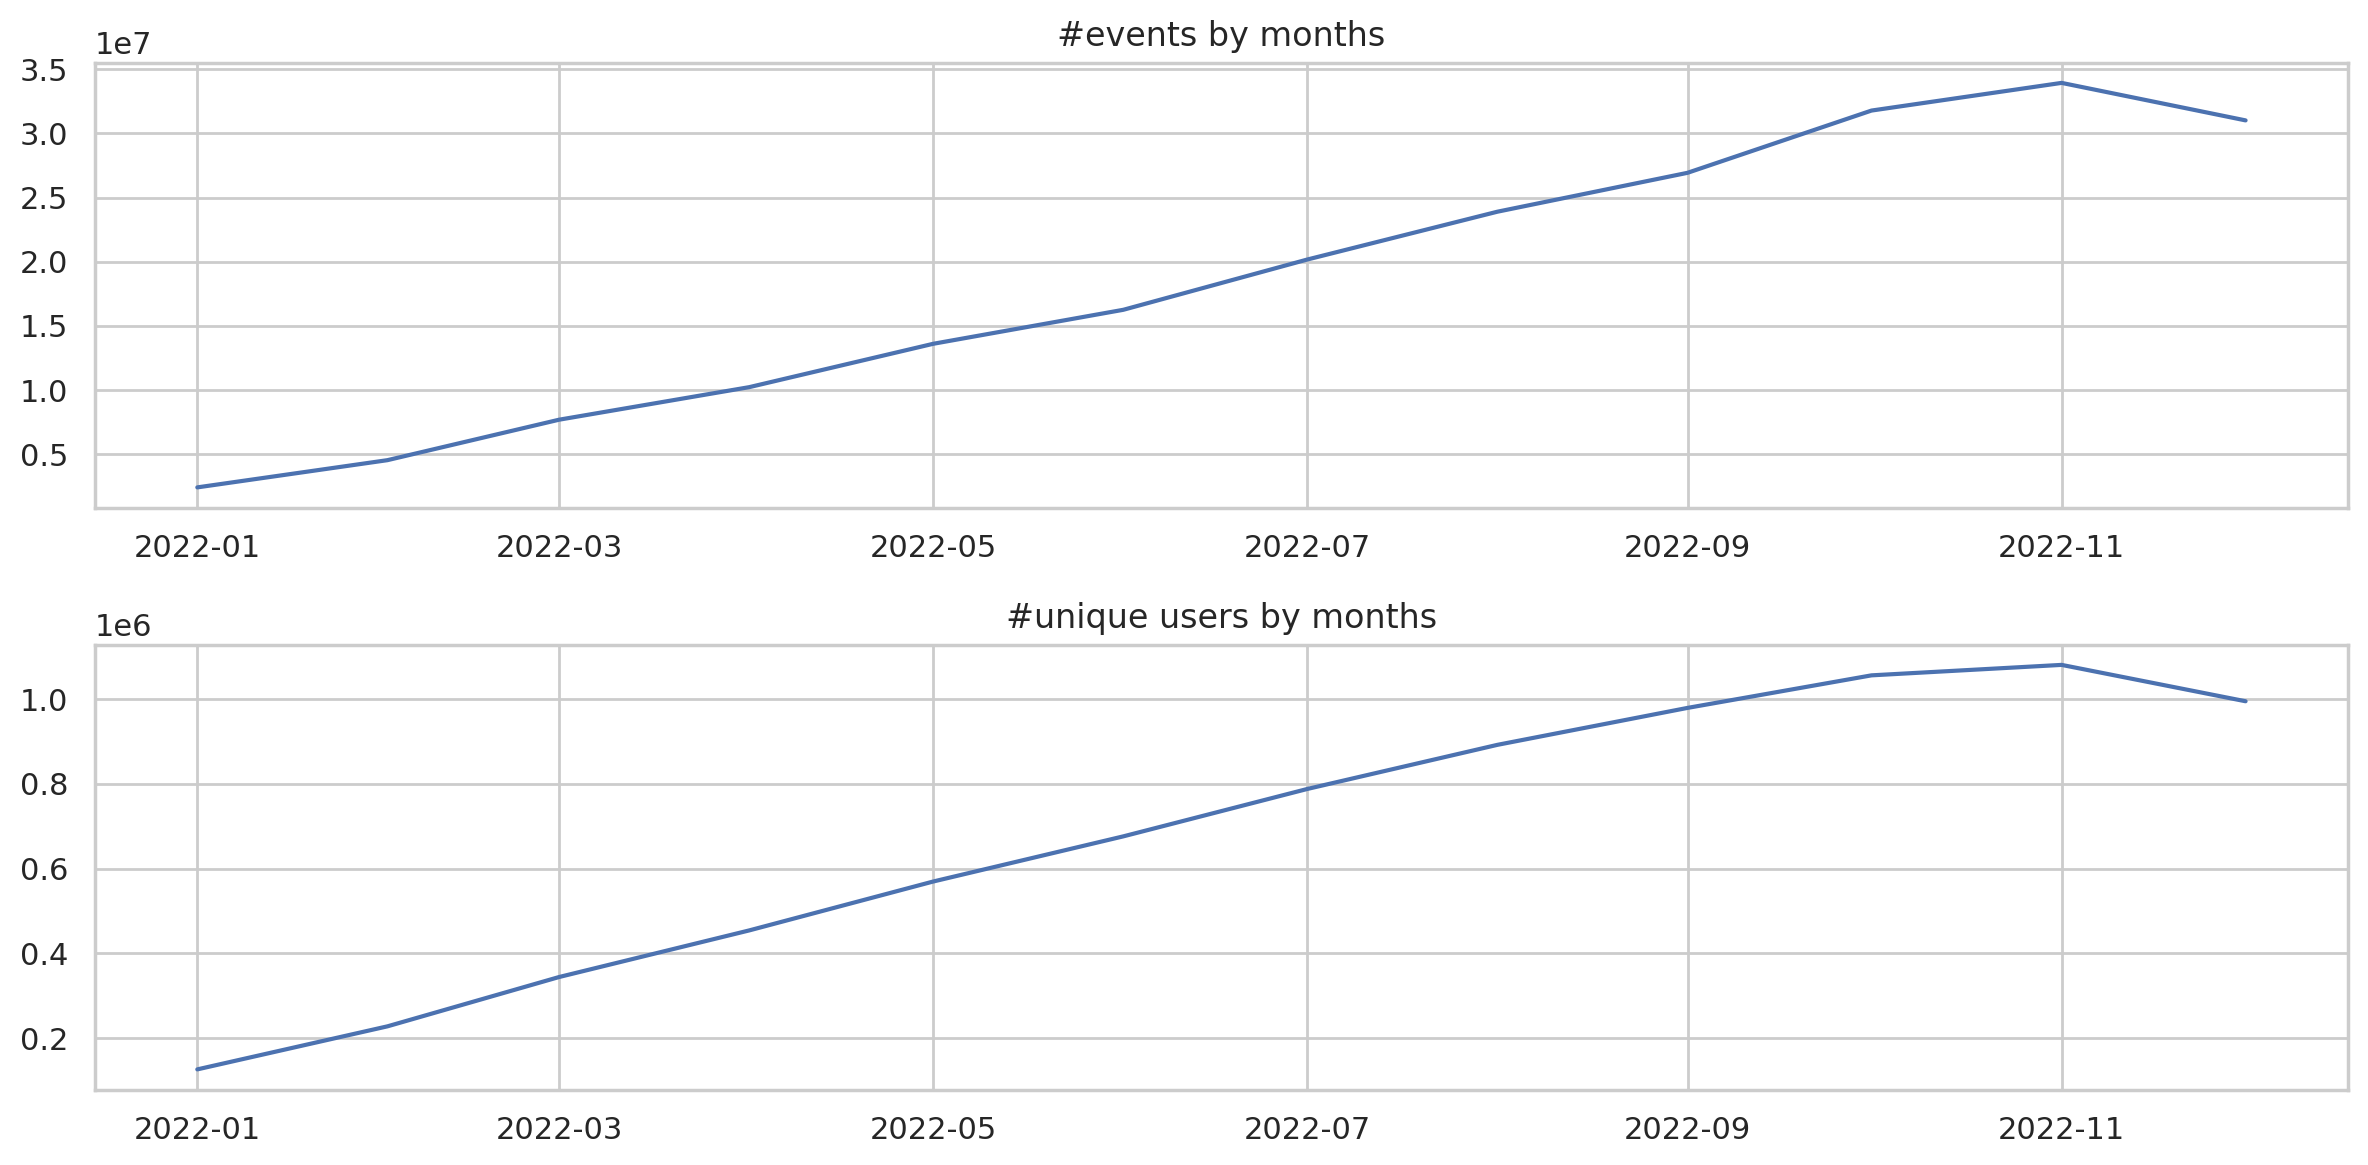

In [8]:
# Визуализируем распределение кол-ва взаимодействий и уникальных пользователей по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_by_month["started_at_month"], events_by_month["events"])
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_by_month["started_at_month"], events_by_month["users"])
ax.set_title("#unique users by months")

fig.tight_layout()

Видим, что история взаимодействий охватывает только 2022 г. Кол-во прослушиваний и уникальных пользователей постепенно росло вплоть до ноября, после чего начало немного снижаться. Возможно, сервис был запущен в самом начале 2022 г., пик его популярности пришелся на конец года и затем начал спадать. Такое изменение в распределении данных может привести к низким оценкам качества рекомендаций при их валидации.

Найдем топ-100 наиболее популярных треков по общему кол-ву прослушиваний.

In [32]:
pop_items = events \
    .groupby("item_id").agg(plays=("started_at", "count"), users=("user_id", "nunique")).reset_index()

# Сортируем по убыванию кол-ва прослушиваний, а при их равенстве - по убыванию уникальных пользователей
pop_items = pop_items.sort_values(['plays', 'users'], ascending=[False, False])

# Выбираем первые 100 самых прослушиваемых треков 
top_k_pop_items = pop_items[:100].reset_index().drop(columns='index')

In [33]:
# Добавляем колонки с названиями всех каталожных единиц
top_k_pop_items = top_k_pop_items \
    .merge(items[['item_id', 'name', 'genres', 'artists', 'albums']], how='inner', on='item_id')

# Добавляем колонку rank
top_k_pop_items = top_k_pop_items.reset_index().rename(columns={'index': 'rank'})
top_k_pop_items['rank'] += 1

top_k_pop_items

,item_id,plays,users,name,genres,artists,albums
0,53404,15704,15704,Smells Like Teen Spirit,"[alternative, allrock, rock]",[Nirvana],[Smells Like Teen Spirit / In Bloom / On A Pla...
1,178529,14088,14088,Numb,"[numetal, metal]",[Linkin Park],"[Meteora, 00s Rock Anthems]"
2,37384,12798,12798,Zombie,"[allrock, rock]",[The Cranberries],"[90s Alternative, MNM Sing Your Song: Back To ..."
3,6705392,12735,12735,Seven Nation Army,[alternative],[The White Stripes],"[Pay Close Attention : XL Recordings, Radio 1 ..."
4,33311009,11972,11972,Believer,"[allrock, rock]",[Imagine Dragons],"[Horoscope Tunes: Cancer, Workout Music Hits 2..."


Сохраняем эти данные в файл `top_popular.parquet` для последующего использования в качестве готовых рекомендаций по умолчанию.

In [34]:
top_k_pop_items.to_parquet('top_popular.parquet')

Определим самые популярные жанры. Для этого пройдемся по только что отобранным топ-трекам и посчитаем, к каким жанрам они относятся. Жанры с наибольшей встречаемостью будут самыми популярными.

In [35]:
# Функция для извлечения жанров из треков
def get_genres(items):

    """ 
    Извлекает жанры из треков и считает, сколько раз встречается каждый жанр.
    """    
    genres_counter = {}
    
    for k, v in items.iterrows():
        if v["genres"] is None: # После предобработки NA быть не может, оставили для общего случая
            continue
        
        genres = list(v["genres"])

        for genre in genres:
            try:
                genres_counter[genre] += 1 
            except KeyError:
                genres_counter[genre] = 1

    genres = pd.Series(genres_counter, name="items_count")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
    genres.index.name = "genre_id"

    return genres

In [36]:
# Извлекаем жанры из самых популярных треков и считаем score для каждого жанра, как долю от общего кол-ва треков
top_k_pop_items_genres = get_genres(top_k_pop_items)
top_k_pop_items_genres["score"] = top_k_pop_items_genres["items_count"] / top_k_pop_items_genres["items_count"].sum()

Text(0.5, 1.0, 'Top 10 most played genres')

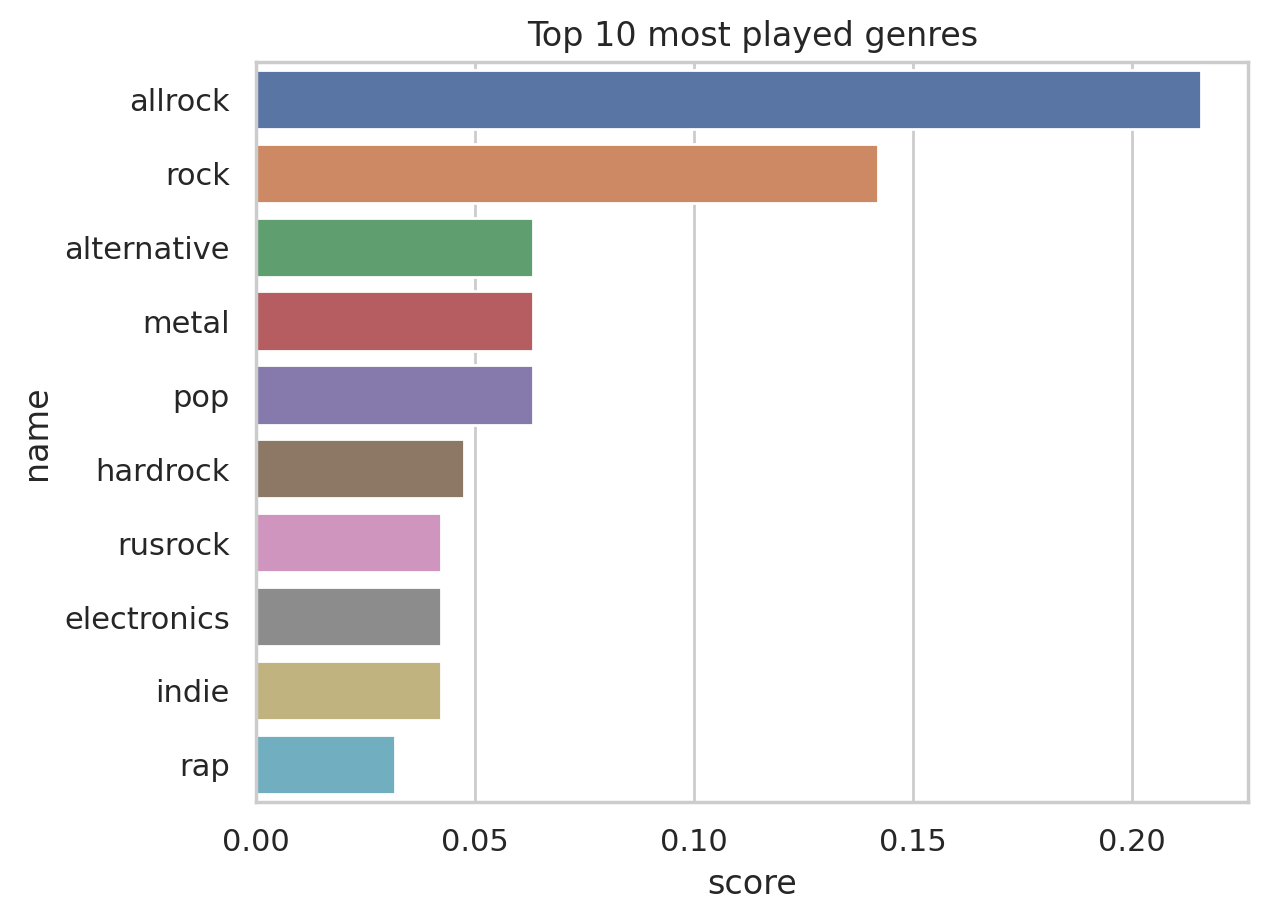

In [37]:
# Строим горизонтальный barplot
sns.barplot(data=top_k_pop_items_genres.sort_values(by="score", ascending=False).head(10), x='score', y='name').set_title("Top 10 most played genres")

Таким образом, в топ-100 самых прослушиваемых треков среди самых активных пользователей наиболее распространенным жанром является allrock.

Также подготовим список жанров по всем трекам. Он понадобится для построения контентных рекомендаций.

In [38]:
# Извлекаем жанры по всем трекам
genres = get_genres(items)
genres["score"] = genres["items_count"] / genres["items_count"].sum()

In [39]:
# Смотрим отсортированный список жанров
genres.sort_values(by="score", ascending=False)

,name,items_count,score
genre_id,,,
0,pop,166284,0.103221
20,rap,128212,0.079588
2,allrock,118506,0.073563
11,electronics,114232,0.070910
6,metal,72311,0.044887
...,...,...,...
124,artwork,7,0.000004
128,religion,4,0.000002
135,technologies,4,0.000002


После всех удалений у нас получилось 137 разных жанров. Из них топ-3 самых распространенных: pop, rap и allrock.

In [40]:
# Сохраняем жанры в файл
genres.to_parquet('genres.parquet')

Проверим кол-во непрослушанных треков, т.е. таких, которые есть в `items`, но нет в `events`.

In [41]:
# Уникальные id всех треков
all_items_ids = set(items['item_id'])
        
# Уникальные id только прослушанных треков
played_items_ids = set(events['item_id'].unique()) 

# Треки, которые есть в items, но нет в events
not_played_items_ids = list(all_items_ids - played_items_ids)
print(f"Кол-во непрослушанных треков: {len(not_played_items_ids)}")

Кол-во непрослушанных треков: 32271


После удаления части записей из истории взаимодействий появилось много непрослушанных треков,
но мы не будем их удалять, т.к. по ним все равно можно строить контентные рекомендации. 

В конце сохраняем файлы с объектами и событиями в S3-хранилище

In [ ]:
# Сохраняем файлы в S3-хранилище
s3.upload_file('items.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/data/items.parquet')
s3.upload_file('events.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/data/events.parquet')

## Этап 3. Оффлайн-рекомендации <a id="step_3"></a>

### Постановка задачи

Подготовьте данные для обучения:
- Загрузите ранее сохранённые данные из файлов `items.parquet`, `events.parquet`;
- Разбейте данные на тренировочную и тестовую выборки: в тренировочную отнесите все данные до __16 декабря 2022 г. (не включительно)__.

Рассчитайте рекомендации нескольких типов, сохраните каждый тип в своём файле в персональном S3-бакете по пути `recsys/recommendations/`:
- топ популярных — в `top_popular.parquet`,
- персональные (при помощи ALS) — в `personal_als.parquet`,
- похожие треки или i2i (при помощи ALS) — в `similar.parquet`.

Постройте ранжирующую модель, которая использует минимум три признака. Отранжируйте рекомендации, а итоговые сохраните в `recommendations.parquet`.

Проверьте оценку качества трёх типов рекомендаций: 
1. топ популярных,
2. персональных, полученных при помощи ALS,
3. итоговых (по метрикам: recall, precision, coverage, novelty).

Приведите значения метрик в ноутбуке.

### Загрузка и разбиение данных

При необходимости перезапускаем ядро и заново загружаем данные

In [ ]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

Разбиваем данные на тренировочную и тестовую выборки (в последнюю относим данные строго до 16 декабря 2022 г.)

In [ ]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

### Рекомендации на основе самых популярных треков

Загружаем ранее сохраненные топ-треки и оцениваем качество рекомендаций на их основе для "холодных" пользователей

In [ ]:
# Загружаем топ-100 самых прослушиваемых треков
top_k_pop_items = pd.read_parquet("top_popular.parquet")
top_k_pop_items.head()

In [ ]:
# Идентификаторы уникальных пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

In [ ]:
# Идентификаторы "холодных" пользователей
cold_users = users_test[~users_test.isin(users_train)]
print(f"Кол-во холодных пользователей: {len(cold_users)}")

Удаление большого кол-ва записей из истории взаимодействий привело к тому, что холодных пользователей не оказалось. 
Из-за этого оценить показатели рекомендаций по умолчанию не получится.

Ниже показан код для расчета метрик валидации, он выдает пустые значения из-за отсутствия холодных пользователей.

In [ ]:
# Формируем бинарные колонки target и prediction

top_k_pop_items['match'] = 1

cold_users_events = \
    events_test[events_test["user_id"].isin(cold_users)] \
        .merge(top_k_pop_items[['item_id', 'match']], on="item_id", how="left")

cold_users_events['match'].fillna(0, inplace=True)

In [ ]:
# Доля событий у "холодных" пользователей, совпавших с рекомендациями по умолчанию
cold_user_recs_matched_share = cold_user_events['match'].sum() / len(cold_user_recs)
cold_user_recs_matched_share

In [ ]:
# Считаем покрытие "холодных" пользователей рекомендациями.
cold_users_hit_ratio = cold_users_events.groupby("user_id").agg(hits=("match", 'sum'))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

### Персональные рекомендации на основе коллаборативного подхода и ALS

[Техническая документация на библиотеку implicit](https://benfred.github.io/implicit/api/models/cpu/als.html)

Перекодируем идентификаторы `user_id` и `item_id`

In [ ]:
# Перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# Перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train = events_train.merge(items[["item_id", "item_id_enc"]], on="item_id", how='left')
events_test = events_test.merge(items[["item_id", "item_id_enc"]], on="item_id", how='left')

Создаем sparse-матрицу в формате [CSR](https://docs.scipy.org/doc/scipy/reference/sparse.html)

In [ ]:
# Формируем колонку target (1 - трек прослушан, 0 - нет)
events_train['target'] = 1

# Создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["target"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

Имея подготовленную матрицу взаимодействий, создаем ALS-модель. 
Для примера возьмём количество латентных факторов для матриц $P и Q$ равным 50. 

In [ ]:
# Код для создания и тренировки модели
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

In [ ]:
# Сохраняем als-модель в файл
os.makedirs('models/', exist_ok=True)
with open('models/als_model.pkl', 'wb') as fd:
    joblib.dump(als_model, fd)

Чтобы получить рекомендации для отдельного пользователя с помощью модели ALS, используем функцию ниже

In [ ]:
def get_recommendations_als(user_item_matrix, als_model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = als_model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

Посмотрим историю и рекомендации для случайного пользователя.

In [ ]:
# Выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]
print(f"user_id: {user_id}")

print("Последние события:")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["name", "genres", "albums", "artists"]], on="item_id")
)
user_history_to_print = user_history[["item_id", "name", "genres", "albums", "artists"]].tail(10)
display(user_history_to_print)

print("Рекомендации:")
user_recommendations = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder, include_seen=True, n=10)
user_recommendations = user_recommendations.merge(items.set_index("item_id")[["name", "genres", "albums", "artists"]], on="item_id")
user_recommendations_to_print = \
    user_recommendations[["item_id", "name", "genres", "albums", "artists", "score"]].head(10)
display(user_recommendations_to_print)

Видим, что рекомендации хорошо мэтчатся с историей пользователя.

Получим рекомендации для всех имеющихся пользователей.

In [ ]:
# Получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# Получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=100)

Код возвращает рекомендации как список списков, что не очень удобно. Преобразуем его в более удобный табличный формат

In [ ]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [ ]:
# Смотрим, что получилось
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.head()

In [ ]:
# Сохраним полученные рекомендации в файл
als_recommendations.to_parquet("personal_als.parquet")

Найдем покрытие по объектам

In [ ]:
cov_items = als_recommendations['item_id'].nunique() / len(items) 
print(cov_items)

Посчитаем среднее Novelty@5, для этого:
- разметим каждую рекомендацию в als_recommendations булевым признаком played, используя events_train
(False — пользователь не прослушал трек, True — прослушал),
- посчитаем Novelty@5 для каждого пользователя,
- найдем среднее значение полученных Novelty@5.

In [ ]:
# разметим каждую рекомендацию признаком played
events_train["played"] = True
als_recommendations = als_recommendations \
    .merge(events_train[['played', "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
als_recommendations["played"] = als_recommendations["played"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values(by='score', ascending=False) 
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - als_recommendations.query("rank <= 5").groupby("user_id")["played"].mean())

# посчитаем средний novelty
novelty_5_mean = novelty_5.mean()
print(novelty_5_mean)

Посчитаем recall и precision для ALS-рекомендаций. Для этого события в тестовой выборке и рекомендации для одних и тех же пользователей разметим признаками:
- gt (ground truth): объект есть в тестовой выборке;
- pr (predicted): объект есть в рекомендациях.

Теперь разметим признаки бинарной классификации:
- TP: объект есть и в тестовой выборке, и в рекомендациях (истинная рекомендация),
- FP: объекта нет в тестовой выборке, но он есть в рекомендациях (ложноположительная рекомендация),
- FN: объект есть в тестовой выборке, но его нет в рекомендациях (ложноотрицательная рекомендация)

Создаем функцию для подсчета метрик TP, FP и FN у пользователей, которые есть одновременно и в events_train,
и в events_test

In [ ]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

Считаем TP, FP и FN для каждой пары user_id, item_id

In [ ]:
events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(events_train,
                                                                        events_test, 
                                                                        als_recommendations,
                                                                        top_k=5)

Считаем precision и recall

In [ ]:
def compute_cls_metrics(events_recs_for_binary_metrics):
    
    groupper = events_recs_for_binary_metrics.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum()) 
    recall = recall.fillna(0).mean()

    return precision, recall

In [ ]:
precision, recall = compute_cls_metrics(events_recs_for_binary_metrics)
print(precision, recall)

### Рекомендации на основе контентного подхода и ALS

Для экономии ресурсов не будем строить контентные рекомендации для всех пользователей. Вместо этого 
найдем матрицу трек-жанр для всех треков. Она понадобится для генерации жанровых признаков.

Сначала загрузим список жанров по всем трекам

In [ ]:
genres = pd.read_parquet('genres.parquet')
genres.head()

Функция ниже строит матрицу трек-жанр

In [ ]:
def get_item2genre_matrix(genres, items):

    genre_names_to_id = genres.reset_index().set_index("name")["genre_id"].to_dict()
    
    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for item_idx, (k, v) in enumerate(items.iterrows()):
        if v["genres"] is None: # После предобработки NA быть не может, оставили для общего случая
            continue
        
        item_genres = list(v["genres"])
        
        for genre_name in item_genres:
            genre_idx = genre_names_to_id[genre_name]
            genres_csr_data.append(1)
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), \
                                         shape=(len(items), len(genres)))
    # нормализуем, чтобы сумма оценок принадлежности к жанрам была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr

Строим матрицу с весами по жанрам по всем трекам

In [ ]:
items = items.sort_values(by="item_id_enc")
all_items_genres_csr = get_item2genre_matrix(genres, items)

### Рекомендации на основе похожих треков (i2i) и ALS

Получим рекомендации при помощи метода [similar_items](https://benfred.github.io/implicit/api/models/cpu/als.html). 
Для экономии ресурсов возьмем не все объекты из `events_train`, а только часть.

In [ ]:
# Загружаем ALS-модель
with open('models/als_model.pkl', 'rb') as fd:
    als_model = joblib.load(fd)

In [ ]:
# Кол-во объектов из events_train, для которых будем искать похожие треки
items_num = 100000

In [ ]:
# Получим энкодированные идентификаторы объектов в events_train
train_item_ids_enc = events_train['item_id_enc'].unique()[:items_num]

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()}) 
similar_items = similar_items.explode(['sim_item_id_enc', 'score'], ignore_index=True) 

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype('int') 
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"]) 
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"]) 
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [ ]:
# Смотрим результат
similar_items.head()

In [ ]:
# Сохраняем полученные рекомендации в файл
similar_items.to_parquet("similar.parquet")

С помощью функции ниже можно посмотреть рекомендации для одного трека

In [ ]:
def print_sim_items(item_id, similar_items):
    item_columns_to_use = ["item_id", "name", "genres", "artists", "albums"]
    
    item_id_1 = items.query("item_id == @item_id")[item_columns_to_use]
    display(item_id_1)
    
    si = similar_items.query("item_id_1 == @item_id")
    si = si.merge(items[item_columns_to_use].set_index("item_id"), left_on="item_id_2", right_index=True)
    display(si)

In [ ]:
# Задаем произвольный трек
item_id = similar_items['item_id_1'].sample().iat[0]

# Смотрим похожие треки
print_sim_items(item_id, similar_items)

Видим, что найденные объекты действительно похожи на заданный.

### Построение ранжирующей модели

Для обучения ранжирующей модели возьмём коллаборативные рекомендации. 
Кроме того, добавим кол-во треков, прослушанных каждым пользователем.
Также сгенерируем парные признаки, характеризующие жанровые предпочтения пользователей. 
Для экономии ресурсов возьмём не все жанры, а только 10 наиболее популярных. Все остальные отметим как не вошедшие в 
топ и обозначим как others. 

In [ ]:
# загружаем коллаборативные рекомендации
als_recommendations = pd.read_parquet("personal_als.parquet")

# Переименовываем 
candidates = als_recommendations
candidates.rename(columns={'score': 'als_score'}, inplace=True)

Добавим в candidates таргеты, используя историю взаимодействий в events_train:
- 1 - для прослушанных item_id (положительный пример),
- 0 - для всех остальных (негативный пример).

In [ ]:
# Добавляем таргет к кандидатам
events_train["target"] = 1
candidates = candidates.merge(events_train[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], 
                              how='left') 
candidates["target"] = candidates["target"].fillna(0).astype("int")

candidates_for_train = candidates

Добавим признак пользователей - количество треков, прослушанных каждым пользователем

In [ ]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    user_features = events.groupby("user_id").agg(
        tracks_played_by_user =("started_at", "count")
    )

    return user_features
    

user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

Добавляем парные признаки, по одному на каждый жанр, которые совместно показывают, какие жанры предпочитает пользователь.

In [ ]:
# определяем индексы топ-10 жанров и всех остальных
genres_top_k = 10
genres_top_idx = genres.sort_values("items_count", ascending=False).head(genres_top_k).index
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column] 

# составляем таблицу принадлежности книг к жанрам
item_genres = (
    pd.concat([
        # топ жанров
        pd.DataFrame(all_items_genres_csr[:, genres_top_idx].toarray(), columns=genres_top_columns), 
        # все остальные жанры
        pd.DataFrame(all_items_genres_csr[:, genres_others_idx].sum(axis=1), columns=[genres_others_column])
        ],
        axis=1)
    .reset_index()
    .rename(columns={"index": "item_id_enc"})
)

# объединяем информацию принадлежности книг к жанрам с основной информацией о книгах
items = items.merge(item_genres, on="item_id_enc", how="left")


def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        .groupby("user_id")[item_genre_columns].mean()
    )
    return user_genres
    

user_genres_for_train = get_user_genres(events_train, items, genre_columns) # ваш код здесь
candidates_for_train = candidates_for_train.merge(user_genres_for_train, on="user_id", how="left")

In [ ]:
# Смотрим результат
candidates_for_train

Обучаем модель

In [ ]:
# задаём имена колонок признаков и таргета
features = ['als_score', 'tracks_played_by_user'] + genre_columns
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

In [ ]:
# Сохраняем ранжирующую модель
os.makedirs('models/', exist_ok=True)
cb_model.save_model('models/cb_model.cbm')

Теперь можно получить финальные рекомендации, используя обученную модель.

In [ ]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_for_train[candidates_for_train["user_id"].isin(events_test["user_id"].drop_duplicates())]

inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby('user_id').cumcount() + 1 

max_recommendations_per_user = 100
recommendations = candidates_to_rank.query('rank <= @max_recommendations_per_user') \
    .rename(columns={"cb_score": "score"}) \
        .drop(columns='target')

In [ ]:
# Смотрим результат
recommendations

In [ ]:
# Сохраняем финальные персональные рекомендации в файл
recommendations.to_parquet("recommendations.parquet")

Проведем валидацию финальных рекомендаций.

Посчитаем метрики recall и precision, используя отложенную тестовую выборку, 
а также функции process_events_recs_for_binary_metrics и compute_cls_metrics.

In [ ]:
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_train,
    events_test, 
    recommendations, 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5) 

In [ ]:
print(f"precision: {cb_precision_5}, recall: {cb_recall_5}")

Найдем покрытие по объектам

In [ ]:
cov_items = recommendations['item_id'].nunique() / len(items) 
print(cov_items)

Посчитаем среднее Novelty@5

In [ ]:
# разметим каждую рекомендацию признаком played
events_train["played"] = True
recommendations = recommendations \
    .merge(events_train[['played', "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
recommendations["played"] = recommendations["played"].fillna(False).astype("bool")

# проставим ранги
recommendations = ecommendations.sort_values(by='score', ascending=False) 
recommendations["rank"] = recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - recommendations.query("rank <= 5").groupby("user_id")["played"].mean())

# посчитаем средний novelty
novelty_5_mean = novelty_5.mean()
print(novelty_5_mean)

Посмотрим, какие признаки вносят наибольший вклад в ранжирование

In [ ]:
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"])

feature_importance = feature_importance.sort_values('fi', ascending=False)
feature_importance

В конце сохраняем файлы с рекомендациями в S3-хранилище

In [ ]:
# Сохраняем файлы в S3-хранилище

s3.upload_file('top_popular.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/top_popular.parquet')
s3.upload_file('personal_als.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/personal_als.parquet')
s3.upload_file('similar.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/similar.parquet')
s3.upload_file('recommendations.parquet', os.environ.get("S3_BUCKET_NAME"), 'recsys/recommendations/recommendations.parquet')